In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [ ]:
model = load_model("./models/resnet50_cancer_model-MRI-finetuned-version-1.keras")

2025-10-04 06:31:13.511580: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-04 06:31:13.555320: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-04 06:31:13.555360: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-04 06:31:13.557025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-04 06:31:13.557051: I external/local_xla/xla/stream_executor

In [10]:
DATASET_PATH = "./dataset_mri"

temp_ds = image_dataset_from_directory(
    DATASET_PATH,
    labels='inferred',
    label_mode='categorical',
    batch_size=1,  
    image_size=(224, 224)
)

# Extract class names
class_names = temp_ds.class_names
print("Class names:", class_names)

Found 24877 files belonging to 10 classes.
Class names: ['brain_glioma_tumor', 'brain_meningioma_tumor', 'brain_normal', 'brain_pituitary_tumor', 'kidney_cyst', 'kidney_normal', 'kidney_stone', 'kidney_tumor', 'pancreatic_normal', 'pancreatic_tumor']


In [11]:
img_path = "./test-image-MRI/4.jpg"
#class_names = ['brain_glioma_tumor', 'brain_meningioma_tumor', 'brain_normal', 'brain_pituitary_tumor', 'kidney_cyst', 'kidney_normal', 'kidney_stone', 'kidney_tumor', 'pancreatic_normal', 'pancreatic_tumor']
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)

In [ ]:
pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)[0]
confidence = np.max(pred)

# Output result
print(f"Predicted class index: {pred_class}")
print(f"Predicted class name: {class_names[pred_class]}")
print(f"Confidence: {confidence:.4f}")

I0000 00:00:1759559676.922204    1566 service.cc:145] XLA service 0x799f9c045860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759559676.922263    1566 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-10-04 06:34:36.997277: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-04 06:34:37.413702: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


1/1 ━━━━━━━━━━━━━━━━━━━━ 113s 113s/step
Predicted class index: 4
Predicted class name: kidney_cyst
Confidence: 1.0000


I0000 00:00:1759559679.863674    1566 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [ ]:
# Get the last conv layer
last_conv_layer = model.get_layer("conv5_block3_out")

# Get the final output layer 
output_layer = model.layers[-1]  

# Build Grad-CAM model using layer tensors
grad_model = Model(
    inputs=model.input,
    outputs=[last_conv_layer.output,
             output_layer.output[0]]
)




In [ ]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[pred_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

In [ ]:

heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)


original_img = cv2.imread(img_path)
original_img = cv2.resize(original_img, (224, 224))

# Superimpose heatmap onto original image
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)


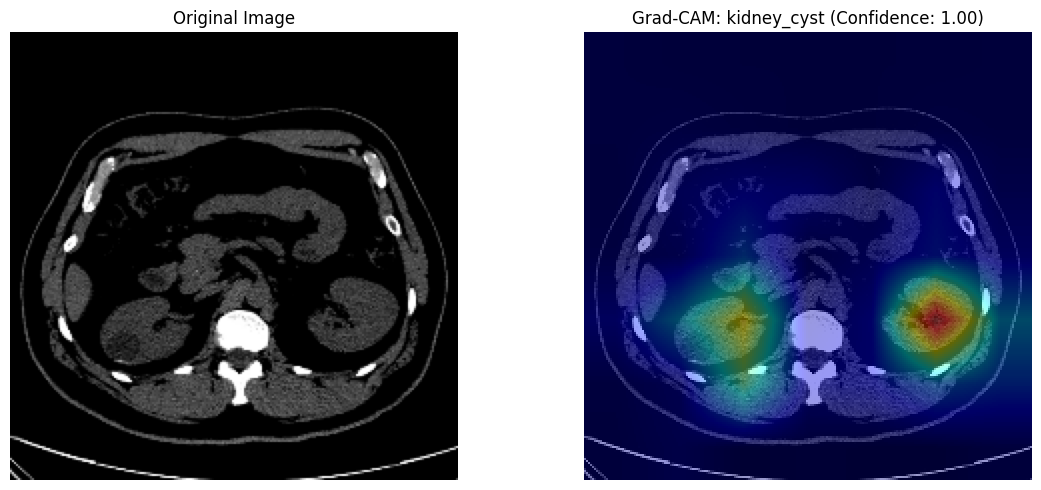

In [22]:
original_img = cv2.imread(img_path)
original_img = cv2.resize(original_img, (224, 224))
original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(12, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_rgb)
plt.title("Original Image")
plt.axis('off')

# Grad-CAM overlay
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM: {class_names[pred_class]} (Confidence: {confidence:.2f})")
plt.axis('off')

plt.tight_layout()
plt.show()
